In [1]:
import numpy as np

import torch
from torch import nn
from torch import optim

import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

/Users/binom/.anaconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('..')

from samplers import mala, i_sir, ex2_mcmc

In [3]:
from mnist_2d_experiments.models import GeneratorMNIST, DiscriminatorMNIST

In [4]:
device = 'cpu'

In [5]:
gen_mnist = GeneratorMNIST(2)
gen_mnist.to(device)

discr_mnist = DiscriminatorMNIST()
discr_mnist.to(device)

prior_mnist = torch.distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

In [6]:
gen_mnist.load_state_dict(torch.load('./weights/vanilla_gan_2d.ckpt')[0])
discr_mnist.load_state_dict(torch.load('./weights/vanilla_gan_2d.ckpt')[1])
gen_mnist.eval()
discr_mnist.eval();

In [7]:
def get_energy_vanilla_gan(z):
    return (-discr_mnist(gen_mnist(z)).squeeze() - prior_mnist.log_prob(z).squeeze())

def log_target_dens(x):
    """
    returns the value of a target density - mixture of the 3 gaussians 
    """
    x = torch.FloatTensor(x)[None, :]
    return -get_energy_vanilla_gan(x).detach().cpu().numpy()

def grad_log_target_dens(x):
    """
    returns the gradient of log-density 
    """
    x = torch.FloatTensor(x)[None, :]
    x.requires_grad_(True)
    external_grad = torch.tensor(1.)
    (-get_energy_vanilla_gan(x)).backward(gradient=external_grad)
    return x.grad.data.detach().cpu().numpy()[0]

### Put parameters of the target density

In [8]:
a = 2.0
mu = a*np.array([[0.0,1.0],[np.sqrt(3)/2,-0.5],[-np.sqrt(3)/2,-0.5]])
sigma = 1.0
print(mu.shape)

(3, 2)


100%|███████████████████████████████████████████| 79/79 [00:09<00:00,  7.98it/s]


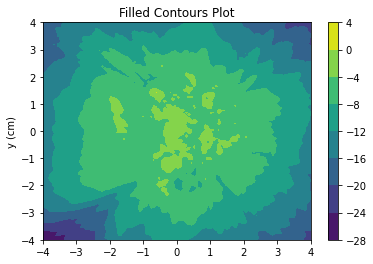

In [9]:
N_pts = 100
xlist = np.linspace(-2*a, 2*a, N_pts)
ylist = np.linspace(-2*a, 2*a, N_pts)
X, Y = np.meshgrid(xlist, ylist)
points = np.zeros((X.shape[0],X.shape[1], 2),dtype=float)
points[:, :, 0] = X
points[:, :, 1] = Y

points = points.reshape(-1, 2)

batch_size = 128

dens_vals = []
for i in tqdm.tqdm(range(points.shape[0] // batch_size + (1 if points.shape[0] % batch_size else 0))):
    z = torch.FloatTensor(points[i * batch_size: (i + 1) * batch_size]).to(device)
    dens_vals.append(-get_energy_vanilla_gan(z).detach().cpu().numpy())

dens_vals = np.concatenate(dens_vals).reshape(N_pts, N_pts)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

In [10]:
N_samples = 100
N_particles = 3
gamma = 0.2
N_steps_mala = 3
sigma_isir = 3.0

def log_dens_isir(x,sigma):
    """
    compute log-density of a normal distributio nwith standard deviation sigma**2
    """
    return -np.sum(x**2)/(2*sigma**2)

### sample i-sir
Samples_isir = np.zeros((N_samples,2),dtype = float)
x0 = np.zeros(2)
x_cur = x0
np.random.seed(42)
for i in tqdm.tqdm(range(N_samples)):
    x_cur = i_sir(log_target_dens, log_dens_isir, x_cur, N_particles, sigma_isir)
    Samples_isir[i] = x_cur

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 31.89it/s]


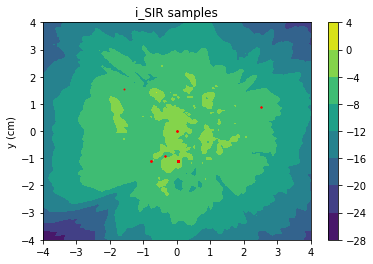

In [11]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals)
fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(Samples_isir[:,0],Samples_isir[:,1], s=1, c='r')
ax.set_title('i_SIR samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

In [12]:
### sample mala
Samples_mala = np.zeros((N_samples,2),dtype = float)
x0 = np.zeros(2)
x_cur = x0
n_accepts = 0
np.random.seed(42)

def logp_mala(grad_log_target_dens, y,z,gamma):
    return -1/(4*gamma)*(np.sum(y - z - gamma*grad_log_target_dens(z))**2)

for i in tqdm.tqdm(range(N_samples)):
    x_cur = mala(log_target_dens, grad_log_target_dens, logp_mala, x_cur,gamma,N_steps_mala, n_accepts)
    Samples_mala[i] = x_cur
    
print("number accepts = ",n_accepts)

100%|█████████████████████████████████████████| 100/100 [00:20<00:00,  4.77it/s]

number accepts =  0


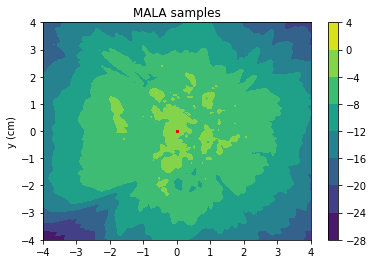

In [13]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals)
fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(Samples_mala[:,0],Samples_mala[:,1], s=1, c='r')
ax.set_title('MALA samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

In [14]:
### sample ex2mcmc
Samples_ex2 = np.zeros((N_samples,2),dtype = float)
x0 = np.zeros(2)
x_cur = x0
n_accepts = 0
np.random.seed(42)

for i in tqdm.tqdm(range(N_samples)):
    x_cur = ex2_mcmc(log_target_dens, grad_log_target_dens, logp_mala, log_dens_isir, x_cur,N_particles,sigma_isir,gamma,N_steps_mala, n_accepts)
    Samples_ex2[i] = x_cur
print("number accepts = ",n_accepts)

100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.23it/s]

number accepts =  0


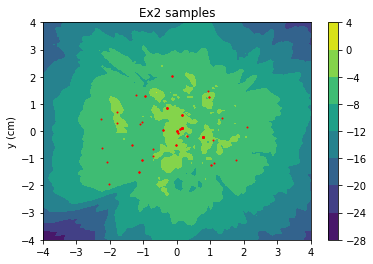

In [15]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals)
fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(Samples_ex2[:,0],Samples_ex2[:,1], s=1, c='r')
ax.set_title('Ex2 samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Plot all 3 pictures together

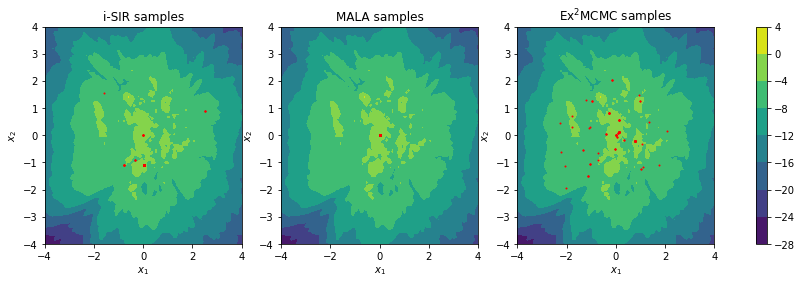

In [16]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
im = ax[0].contourf(X, Y, dens_vals)
im = ax[1].contourf(X, Y, dens_vals)
im = ax[2].contourf(X, Y, dens_vals)
fig.colorbar(im, ax=ax.flat) # Add a colorbar to a plot
#i-sir plots
ax[0].scatter(Samples_isir[:,0],Samples_isir[:,1], s=1, c='r')
ax[0].set_title('i-SIR samples')
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
#mala samples
ax[1].scatter(Samples_mala[:,0],Samples_mala[:,1], s=1, c='r')
ax[1].set_title('MALA samples')
ax[1].set_xlabel('$x_1$')
ax[1].set_ylabel('$x_2$')
#ex2-mcmc samples
ax[2].scatter(Samples_ex2[:,0],Samples_ex2[:,1], s=1, c='r')
ax[2].set_title('Ex$^2$MCMC samples')
ax[2].set_xlabel('$x_1$')
ax[2].set_ylabel('$x_2$')
plt.savefig("./figs/vanilla_gan_2d_lat_samples.pdf", format="pdf", bbox_inches="tight") 
plt.show()

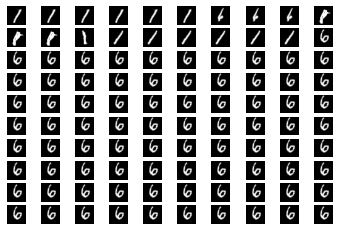

In [17]:
sampled_mnist = gen_mnist(torch.FloatTensor(Samples_isir))

for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')

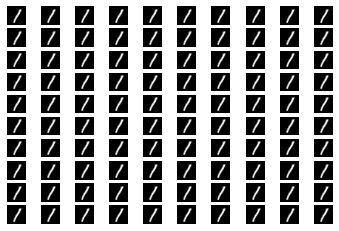

In [18]:
sampled_mnist = gen_mnist(torch.FloatTensor(Samples_mala))

for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')

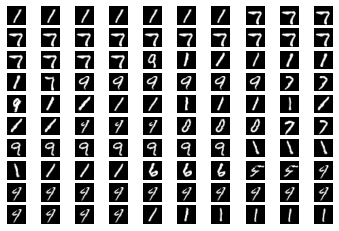

In [19]:
sampled_mnist = gen_mnist(torch.FloatTensor(Samples_ex2))

for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')